<a href="https://colab.research.google.com/github/Chay16/dataflowr-PlutonAI/blob/master/07_RNN_PlutonAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN practicals

This jupyter notebook allows you to reproduce and explore the results presented in the [lecture on RNN](https://mlelarge.github.io/dataflowr-slides/PlutonAI/lesson7.html)

In [0]:
import numpy as np
from collections import OrderedDict
import scipy.special
from scipy.special import binom
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm as tq

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def Catalan(k):
    return binom(2*k,k)/(k+1)

In [0]:
import torch
use_gpu = torch.cuda.is_available()
def gpu(tensor, gpu=use_gpu):
    if gpu:
        return tensor.cuda()
    else:
        return tensor

## 1. Generation a dataset

We have a problem, where we need to generate a dataset made of valid parenthesis strings but also invalid parenthesis string. You can skip to the end of this section to see how parenthesis strings are generated.

In [0]:
seq_max_len = 20
seq_min_len = 4

### generating positive examples

In [0]:
# convention: +1 opening parenthesis and -1 closing parenthesis

def all_parent(n, a, k=-1):
    global res
    if k==n-1 and sum(a) == 0:
        res.append(a.copy())
    elif k==n-1:
        pass
    else:
        k += 1
        if sum(a) > 0:
            a[k] = 1
            all_parent(n,a,k)
        
            a[k] = -1
            all_parent(n,a,k)
            a[k] = 0
        else:
            a[k] = 1
            all_parent(n,a,k)
            a[k] = 0

### generating negative examples

In [0]:
def all_parent_mistake(n, a, k=-1):
    global res
    if k==n-1 and sum(a) >= -1 and sum(a) <= 1 and min(np.cumsum(a))<0:
        res.append(a.copy())
    elif sum(a) > n-k:
        pass
    elif k==n-1:
        pass
    else:
        k += 1
        if sum(a) >= -1 and k != 0:
            a[k] = 1
            all_parent_mistake(n,a,k)
        
            a[k] = -1
            all_parent_mistake(n,a,k)
            a[k] = 0
        else:
            a[k] = 1
            all_parent_mistake(n,a,k)
            a[k] = 0

In [0]:
# numbering the parentheses
# example: seq of len 6
# ( ( ( ) ) ) 
# 0 1 2 4 5 6
# we always have ( + ) = seq_len
# 'wrong' parentheses are always closing and numbered as:
# ) )
# 7 8

def reading_par(l, n):
    res = [0]*len(l)
    s = []
    n_plus = -1
    n_moins = n+1
    c = 0
    for i in l:
        if i == 1:
            n_plus += 1
            s.append(n_plus)
            res[c] = n_plus
            c += 1
        else:
            try:
                res[c] = n-s.pop()
            except:
                res[c] = n_moins
                n_moins += 1
            c += 1
    return res

In [0]:
all_par = OrderedDict()
for n in range(seq_min_len,seq_max_len+1,2):
    a = [0]*n
    res = []
    all_parent(n=n,a=a,k=-1)
    all_par[n] = [reading_par(k,n) for k in res]

In [0]:
all_par_mist = OrderedDict()
for n in range(seq_min_len,seq_max_len+1,2):
    a = [0]*n
    res = []
    all_parent_mistake(n=n,a=a,k=-1)
    all_par_mist[n] = [reading_par(k,n) for k in res]

In [10]:
all_par[6]

[[0, 1, 2, 4, 5, 6],
 [0, 1, 5, 2, 4, 6],
 [0, 1, 5, 6, 2, 4],
 [0, 6, 1, 2, 4, 5],
 [0, 6, 1, 5, 2, 4]]

In [11]:
all_par_mist[6]

[[0, 1, 5, 6, 7, 2],
 [0, 6, 1, 5, 7, 2],
 [0, 6, 7, 1, 2, 4],
 [0, 6, 7, 1, 5, 2],
 [0, 6, 7, 8, 1, 2]]

### number of negative examples by length

In [0]:
long_mist = {i:len(l) for (i,l) in zip(all_par_mist.keys(),all_par_mist.values())}

In [13]:
long_mist

{4: 1, 6: 5, 8: 20, 10: 75, 12: 275, 14: 1001, 16: 3640, 18: 13260, 20: 48450}

### number of positive examples by length

In [0]:
Catalan_num = {i:len(l) for (i,l) in zip(all_par.keys(),all_par.values())}

In [15]:
Catalan_num

{4: 2, 6: 5, 8: 14, 10: 42, 12: 132, 14: 429, 16: 1430, 18: 4862, 20: 16796}

Sanity check, see [Catalan numbers](https://en.wikipedia.org/wiki/Catalan_number)

In [16]:
[(2*i,Catalan(i)) for i  in range(2,int(seq_max_len/2)+1)]

[(4, 2.0),
 (6, 5.0),
 (8, 14.0),
 (10, 42.0),
 (12, 132.0),
 (14, 429.0),
 (16, 1430.0),
 (18, 4862.0),
 (20, 16796.0)]

In [17]:
# nombre de suites correctes de longueur entre 4 et 10, alphabet de taille nb_symbol.
nb_symbol = 10
np.sum([Catalan(i)*int(nb_symbol/2)**i for i in range(2,int(seq_max_len/2)+1)])

174113843800.0

In [0]:
import random
import torch

class SequenceGenerator():
    def __init__(self, nb_symbol = 10, seq_min_len = 4, seq_max_len = 10):
        self.nb_symbol = nb_symbol
        self.seq_min_len = seq_min_len
        self.seq_max_len = seq_max_len
        self.population = [i for i in range(int(nb_symbol/2))]
                
    def generate_pattern(self):
        len_r = random.randint(self.seq_min_len/2,self.seq_max_len/2)
        pattern = random.choices(self.population,k=len_r)
        return pattern + pattern[::-1]
    
    def generate_pattern_parenthesis(self, len_r = None):
        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,Catalan_num[len_r]-1)
        res = [pattern[i] if i <= len_r/2 else self.nb_symbol-1-pattern[len_r-i] for i in all_par[len_r][ind_r]]
        return res
    
    def generate_parenthesis_false(self):
        len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,long_mist[len_r]-1)
        res = [pattern[i] if i <= len_r/2 
               else  self.nb_symbol-1-pattern[len_r-i] if i<= len_r 
               else self.nb_symbol-1-pattern[i-len_r] for i in all_par_mist[len_r][ind_r]]
        return res
    
    def generate_hard_parenthesis(self, len_r = None):
        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,Catalan_num[len_r]-1)
        res = [pattern[i] if i <= len_r/2 else self.nb_symbol-1-pattern[len_r-i] for i in all_par[len_r][ind_r]]
        
        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,Catalan_num[len_r]-1)
        res2 = [pattern[i] if i <= len_r/2 else self.nb_symbol-1-pattern[len_r-i] for i in all_par[len_r][ind_r]]
        return res + res2
    
    def generate_hard_nonparenthesis(self, len_r = None):
        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,long_mist[len_r]-1)
        res = [pattern[i] if i <= len_r/2 
               else  self.nb_symbol-1-pattern[len_r-i] if i<= len_r 
               else self.nb_symbol-1-pattern[i-len_r] for i in all_par_mist[len_r][ind_r]]
        
        if len_r == None:
            len_r = int(2*random.randint(self.seq_min_len/2,self.seq_max_len/2))
        pattern = np.random.choice(self.population,size=int(len_r/2),replace=True)
        ind_r = random.randint(0,Catalan_num[len_r]-1)
        res2 = [pattern[i] if i <= len_r/2 else self.nb_symbol-1-pattern[len_r-i] for i in all_par[len_r][ind_r]]
        return  res +[self.nb_symbol-1-pattern[0]]+ res2
        
    def generate_false(self):
        popu = [i for i in range(nb_symbol)]
        len = random.randint(self.seq_min_len/2,self.seq_max_len/2)
        return random.choices(popu,k=len) + random.choices(popu,k=len)
    
    def generate_label(self, x):
        l = int(len(x)/2)
        return 1 if x[:l] == x[:l-1:-1] else 0
    
    def generate_label_parenthesis(self, x):
        s = []
        label = 1
        lenx = len(x)
        for i in x:
            if s == [] and i < self.nb_symbol/2:
                s.append(i)
            elif s == [] and i >= self.nb_symbol/2:
                label = 0
                break
            elif i == self.nb_symbol-1-s[-1]:
                s.pop()
            else:
                s.append(i)
        if s != []:
            label = 0
        return label
    
    def one_hot(self,seq):
        one_hot_seq = []
        for s in seq:
            one_hot = [0 for _ in range(self.nb_symbol)]
            one_hot[s] = 1
            one_hot_seq.append(one_hot)
        return one_hot_seq
    
    def generate_input(self, len_r = None, true_parent = False, hard_false = True):
        if true_parent:
            seq = self.generate_pattern_parenthesis(len_r)
        elif bool(random.getrandbits(1)):
            seq = self.generate_pattern_parenthesis(len_r)
        else:
            if hard_false:
                seq = self.generate_parenthesis_false()
            else:
                seq = self.generate_false()
        return gpu(torch.from_numpy(np.array(self.one_hot(seq))).type(torch.FloatTensor)), gpu(torch.from_numpy(np.array([self.generate_label_parenthesis(seq)])))

    def generate_input_hard(self,true_parent = False):
        if true_parent:
            seq = self.generate_hard_parenthesis(self.seq_max_len)
        elif bool(random.getrandbits(1)):
            seq = self.generate_hard_parenthesis(self.seq_max_len)
        else:
            seq = self.generate_hard_nonparenthesis(self.seq_max_len)
            
        return gpu(torch.from_numpy(np.array(self.one_hot(seq))).type(torch.FloatTensor)), gpu(torch.from_numpy(np.array([self.generate_label_parenthesis(seq)])))

In [0]:
nb_symbol = 10
generator = SequenceGenerator(nb_symbol = nb_symbol, seq_min_len = seq_min_len, seq_max_len = seq_max_len)

In [20]:
generator.generate_pattern_parenthesis()

[3, 2, 0, 0, 9, 4, 5, 2, 7, 3, 6, 9, 7, 6]

In [0]:
x = generator.generate_parenthesis_false()

In [22]:
generator.generate_label_parenthesis(x)

0

In [23]:
generator.generate_input()

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0'),
 tensor([0], device='cuda:0'))

## 2. First RNN: [Elman network](https://mlelarge.github.io/dataflowr-slides/PlutonAI/lesson7.html#16)

Initial hidden state: $h_0 =0$

Update:

$$
h_t = \mathrm{ReLU}(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

Final prediction:

$$
y_T = W_{hy} h_T + b_y.
$$

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RecNet(nn.Module):
    def __init__(self, dim_input=10, dim_recurrent=50, dim_output=2):
        super(RecNet, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias = False)
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)
        
    def forward(self, x):
        h = x.new_zeros(1, self.fc_h2y.weight.size(1))
        for t in range(x.size(0)):
            h = torch.relu(self.fc_x2h(x[t,:]) + self.fc_h2h(h))    
        return self.fc_h2y(h)
    
RNN = gpu(RecNet(dim_input = nb_symbol))

In [25]:
cross_entropy = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(RNN.parameters(),lr=learning_rate)
nb_train = 40000
loss_t = []
corrects =[]
labels = []
start = time.time()
for k in tq(range(nb_train), desc="Training"):
    x,l = generator.generate_input(hard_false = False)
    y = RNN(x)
    loss = cross_entropy(y,l)
    _,preds = torch.max(y.data,1)
    corrects.append(preds.item() == l.data.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_t.append(loss)
    labels.append(l.data)
print("Total Training Time : {}".format(time.strftime("%M:%S", time.localtime(time.time() - start))))


Total Training Time : 03:02


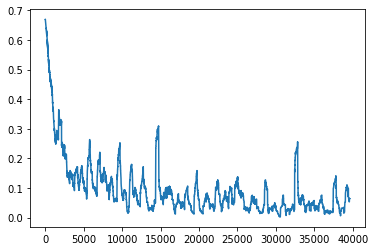

In [26]:
plt.plot(running_mean(loss_t,int(nb_train/100)));

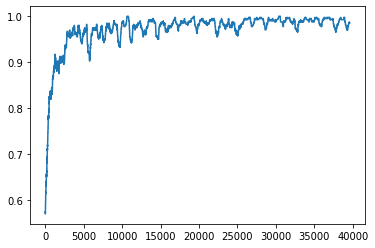

In [27]:
plt.plot(running_mean(corrects,int(nb_train/100)));

In [28]:
nb_test = 1000
corrects_test =[]
labels_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input(len_r=seq_max_len,true_parent=True)
    y = RNN(x)
    _,preds = torch.max(y.data,1)
    corrects_test.append(preds.item() == l.data.item())
    labels_test.append(l.data)

Accuracy on valid parenthesis strings only:

In [29]:
np.sum(corrects_test)/nb_test

1.0

In [30]:
nb_test = 1000
corrects_test =[]
labels_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input(len_r=seq_max_len, hard_false = True)
    y = RNN(x)
    _,preds = torch.max(y.data,1)
    corrects_test.append(preds.item() == l.data.item())
    labels_test.append(l.data)

Accuracy on a test set (similar to the training set):

In [31]:
np.sum(corrects_test)/nb_test

0.805

In [32]:
nb_test = 1000
correctsh_test =[]
labelsh_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input_hard()
    y = RNN(x)
    _,preds = torch.max(y.data,1)
    correctsh_test.append(preds.item() == l.data.item())
    labelsh_test.append(l.data)

Accuracy on a test set of hard instances, i.e. instances longer than those seen during the training :

In [33]:
np.sum(correctsh_test)/nb_test

0.511

In [34]:
nb_test = 1000
correctsh_test =[]
labelsh_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input_hard(true_parent=True)
    y = RNN(x)
    _,preds = torch.max(y.data,1)
    correctsh_test.append(preds.item() == l.data.item())
    labelsh_test.append(l.data)

It looks like our network is always prediciting a valid label for long sequences:

In [35]:
np.sum(correctsh_test)/nb_test

1.0

## 3. [RNN with Gating](https://mlelarge.github.io/dataflowr-slides/PlutonAI/lesson7.html#20)

$$
\overline{h}_t = \mathrm{ReLU}(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$
Forget gate:
$$
z_t = \mathrm{sigm}(W_{xz} x_t + W_{hz}h_{t-1}+b_z)
$$
Hidden state:
$$
h_t = z_t\odot h_{t-1} +(1-z_t) \odot \overline{h}_t
$$

In [0]:
class RecNetGating(nn.Module):
    def __init__(self, dim_input=10, dim_recurrent=50, dim_output=2):
        super(RecNetGating, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias = False)
        self.fc_x2z = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2z = nn.Linear(dim_recurrent,dim_recurrent, bias = False)
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)
        
    def forward(self, x):
        h = x.new_zeros(1, self.fc_h2y.weight.size(1))
        for t in range(x.size(0)):
            z = torch.sigmoid(self.fc_x2z(x[t,:])+self.fc_h2z(h))
            hb = torch.relu(self.fc_x2h(x[t,:]) + self.fc_h2h(h))
            h = z * h + (1-z) * hb   
        return self.fc_h2y(h)    
    
RNNG = gpu(RecNetGating(dim_input = nb_symbol))

In [37]:
optimizerG = torch.optim.Adam(RNNG.parameters(),lr=1e-3)
loss_tG = []
correctsG =[]
labelsG = []
start = time.time()
for k in tq(range(nb_train), desc="Training"):
    x,l = generator.generate_input(hard_false = False)
    y = RNNG(x)
    loss = cross_entropy(y,l)
    _,preds = torch.max(y.data,1)
    correctsG.append(preds.item() == l.data.item())
    optimizerG.zero_grad()
    loss.backward()
    optimizerG.step()
    loss_tG.append(loss)
    labelsG.append(l.item())
print("Total Training Time : {}".format(time.strftime("%M:%S", time.localtime(time.time() - start))))


Total Training Time : 06:55


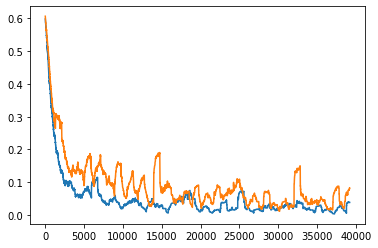

In [38]:
plt.plot(running_mean(loss_tG,int(nb_train/50)))
plt.plot(running_mean(loss_t,int(nb_train/50)));

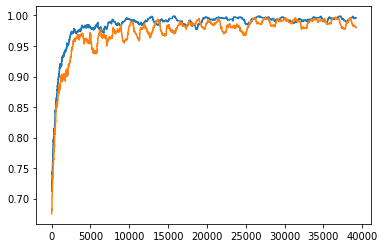

In [39]:
plt.plot(running_mean(correctsG,int(nb_train/50)))
plt.plot(running_mean(corrects,int(nb_train/50)));

In [40]:
nb_test = 1000
correctsG_test =[]
labelsG_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input(len_r=seq_max_len,true_parent=True)
    y = RNNG(x)
    _,preds = torch.max(y.data,1)
    correctsG_test.append(preds.item() == l.data.item())
    labelsG_test.append(l.data)

Accuracy on valid parenthesis strings only:

In [41]:
np.sum(correctsG_test)/nb_test

1.0

In [42]:
nb_test = 1000
correctsG_test =[]
labelsG_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input(len_r=seq_max_len, hard_false = True)
    y = RNNG(x)
    _,preds = torch.max(y.data,1)
    correctsG_test.append(preds.item() == l.data.item())
    labelsG_test.append(l.data)

Accuracy on a test set (similar to the training set):

In [43]:
np.sum(correctsG_test)/nb_test

0.868

In [44]:
nb_test = 1000
correctshG_test =[]
labelshG_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input_hard()
    y = RNNG(x)
    _,preds = torch.max(y.data,1)
    correctshG_test.append(preds.item() == l.data.item())
    labelshG_test.append(l.data)

Accuracy on a test set of hard instances, i.e. instances longer than those seen during the training :

In [45]:
np.sum(correctshG_test)/nb_test

0.601

## 4. [LSTM](https://mlelarge.github.io/dataflowr-slides/PlutonAI/lesson7.html#27)

In [0]:
class LSTMNet(nn.Module):
    def __init__(self, dim_input=10, dim_recurrent=50, num_layers=4, dim_output=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size = dim_input, 
                           hidden_size = dim_recurrent,
                           num_layers = num_layers)
        self.fc_o2y = nn.Linear(dim_recurrent,dim_output)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        output, _ = self.lstm(x)
        output = output.squeeze(1)
        output = output.narrow(0, output.size(0)-1,1)
        return self.fc_o2y(F.relu(output))
    
lstm = gpu(LSTMNet(dim_input = nb_symbol))

In [0]:
x, l = generator.generate_input()

In [63]:
lstm(x)

tensor([[0.0807, 0.0475]], device='cuda:0', grad_fn=<AddmmBackward>)

In [64]:
optimizerL = torch.optim.Adam(lstm.parameters(),lr=1e-3)
loss_tL = []
correctsL =[]
labelsL = []
start = time.time()
for k in tq(range(nb_train), desc="Training"):
    x,l = generator.generate_input(hard_false = False)
    y = lstm(x)
    loss = cross_entropy(y,l)
    _,preds = torch.max(y.data,1)
    correctsL.append(preds.item() == l.data.item())
    optimizerL.zero_grad()
    loss.backward()
    optimizerL.step()
    loss_tL.append(loss)
    labelsL.append(l.item())
print("Total Training Time : {}".format(time.strftime("%M:%S", time.localtime(time.time() - start))))


Total Training Time : 03:49


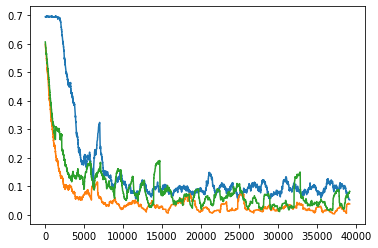

In [65]:
plt.plot(running_mean(loss_tL,int(nb_train/50)))
plt.plot(running_mean(loss_tG,int(nb_train/50)))
plt.plot(running_mean(loss_t,int(nb_train/50)));

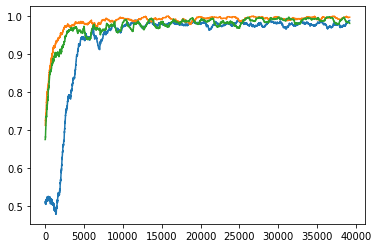

In [66]:
plt.plot(running_mean(correctsL,int(nb_train/50)))
plt.plot(running_mean(correctsG,int(nb_train/50)))
plt.plot(running_mean(corrects,int(nb_train/50)));

In [67]:
nb_test = 1000
correctsL_test =[]
labelsL_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input(len_r=seq_max_len,true_parent=True)
    y = lstm(x)
    _,preds = torch.max(y.data,1)
    correctsL_test.append(preds.item() == l.data.item())
    labelsL_test.append(l.data)

Accuracy on valid parenthesis strings only:

In [68]:
np.sum(correctsL_test)/nb_test

1.0

In [69]:
nb_test = 1000
correctsL_test =[]
labelsL_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input(len_r=seq_max_len,true_parent=False,hard_false = True)
    y = lstm(x)
    _,preds = torch.max(y.data,1)
    correctsL_test.append(preds.item() == l.data.item())
    labelsL_test.append(l.data)

Accuracy on a test set (similar to the training set):

In [70]:
np.sum(correctsL_test)/nb_test

1.0

In [71]:
nb_test = 1000
correctshL_test =[]
labelshL_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input_hard()
    y = lstm(x)
    _,preds = torch.max(y.data,1)
    correctshL_test.append(preds.item() == l.data.item())
    labelshL_test.append(l.data)

Accuracy on a test set of hard instances, i.e. instances longer than those seen during the training :



In [72]:
np.sum(correctshL_test)/nb_test

0.831

## 5. GRU

Implement your RNN with a [GRU](https://pytorch.org/docs/stable/nn.html#gru)

In [0]:
class GRUNet(nn.Module):
    def __init__(self, dim_input=10, dim_recurrent=50, num_layers=4, dim_output=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size = dim_input, 
                           hidden_size = dim_recurrent,
                           num_layers = num_layers)
        self.fc_o2y = nn.Linear(dim_recurrent,dim_output)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        output, _ = self.gru(x)
        output = output.squeeze(1)
        output = output.narrow(0, output.size(0)-1,1)
        return self.fc_o2y(F.relu(output))
    
gru = gpu(GRUNet(dim_input = nb_symbol))

In [74]:
x, l = generator.generate_input()
gru(x)

tensor([[-0.0081, -0.0820]], device='cuda:0', grad_fn=<AddmmBackward>)

In [75]:
optimizerGRU = torch.optim.Adam(gru.parameters(),lr=1e-3)
loss_tGRU = []
correctsGRU =[]
labelsGRU = []
start = time.time()
for k in tq(range(nb_train), desc="Training"):
    x,l = generator.generate_input(hard_false = False)
    y = gru(x)
    loss = cross_entropy(y,l)
    _,preds = torch.max(y.data,1)
    correctsGRU.append(preds.item() == l.data.item())
    optimizerGRU.zero_grad()
    loss.backward()
    optimizerGRU.step()
    loss_tGRU.append(loss)
    labelsGRU.append(l.item())
print("Total Training Time : {}".format(time.strftime("%M:%S", time.localtime(time.time() - start))))


Total Training Time : 03:44


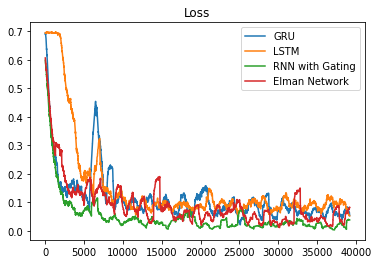

In [76]:
plt.plot(running_mean(loss_tGRU,int(nb_train/50)), label="GRU")
plt.plot(running_mean(loss_tL,int(nb_train/50)), label="LSTM")
plt.plot(running_mean(loss_tG,int(nb_train/50)), label="RNN with Gating")
plt.plot(running_mean(loss_t,int(nb_train/50)), label="Elman Network")
plt.title("Loss")
plt.legend();

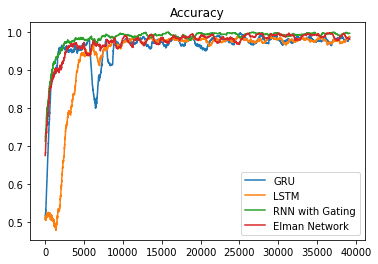

In [77]:
plt.plot(running_mean(correctsGRU,int(nb_train/50)), label="GRU")
plt.plot(running_mean(correctsL,int(nb_train/50)), label="LSTM")
plt.plot(running_mean(correctsG,int(nb_train/50)), label="RNN with Gating")
plt.plot(running_mean(corrects,int(nb_train/50)), label="Elman Network")
plt.title("Accuracy")
plt.legend();

In [78]:
nb_test = 1000
correctsGRU_test =[]
labelsGRU_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input(len_r=seq_max_len,true_parent=True)
    y = gru(x)
    _,preds = torch.max(y.data,1)
    correctsGRU_test.append(preds.item() == l.data.item())
    labelsGRU_test.append(l.data)

Accuracy on valid parenthesis strings only:

In [79]:
np.sum(correctsGRU_test)/nb_test

1.0

In [80]:
nb_test = 1000
correctsGRU_test =[]
labelsGRU_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input(len_r=seq_max_len,true_parent=False, hard_false=True)
    y = gru(x)
    _,preds = torch.max(y.data,1)
    correctsGRU_test.append(preds.item() == l.data.item())
    labelsGRU_test.append(l.data)

Accuracy on a test set (similar to the training set):

In [81]:
np.sum(correctsGRU_test)/nb_test

0.986

In [82]:
nb_test = 1000
correctsGRU_test =[]
labelsGRU_test = []
for k in tq(range(nb_test), desc="Testing"):
    x,l = generator.generate_input_hard()
    y = gru(x)
    _,preds = torch.max(y.data,1)
    correctsGRU_test.append(preds.item() == l.data.item())
    labelsGRU_test.append(l.data)

Accuracy on a test set of hard instances, i.e. instances longer than those seen during the training :

In [83]:
np.sum(correctsGRU_test)/nb_test

0.8

## 6. Explore!

What are good negative examples?

How to be sure that your network 'generalizes'?